# COMP4680/COMP8650 Assignment 5
Longfei Zhao, u5976992

## Linear Programming

In [1]:
import cvxpy as cp
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.sparse import diags

x = cp.Variable(4)
a = np.array([[1, 2, 3, 4]])
a1 = np.ones((1, 4))
a2 = np.array([[1, -1, 1, -1]])

objective = cp.Minimize(a * x)
constraints = [a1 * x == 1, a2 * x == 0, x >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()

print('optimal variables x*: {}'.format(' '.join(map(str, x.value))))
print('optimal value p*: {}'.format(problem.value))

optimal variables x*: 0.5 0.5 1.1102230333719147e-22 -5.551115048125993e-23
optimal value p*: 1.5


## Regularized Maximum Likelihood Estimation.
### (a)

$$ p(x)= (2\pi)^{-\frac{n}{2}} {\rm det}(\Sigma)^{-\frac{1}{2}}{\rm exp}(-\frac{1}{2}(x - \mu)^T \Sigma^{-1}(x - \mu)) $$
Therefore the average log-likelihood of the data is,
$$ \begin{align*}
\ell(\mathcal{D}) 
&= \frac{1}{m}{\rm log}~p(x_1, \dots, x_m) \\
&= \frac{1}{m}{\rm log}~\prod_{i=1}^m p(x_i) \\
&= \frac{1}{m}({-\frac{n}{2}} \sum_{i=1}^m {\rm log}~(2\pi) {-\frac{1}{2}}\sum_{i=1}^m{\rm log~det}~\Sigma -\frac{1}{2} \sum_{i=1}^m (x_i - \mu)^T \Sigma^{-1}(x_i - \mu))) \\
&= {-\frac{n}{2}} {\rm log}~(2\pi) {-\frac{1}{2}}{\rm log~det}~\Sigma -\frac{1}{2m} \sum_{i=1}^m (x_i - \mu)^T \Sigma^{-1}(x_i - \mu)) \\
\end{align*} $$

Since, $\frac{1}{m} \sum_{i=1}^m (x_i - \mu)^T \Sigma^{-1}(x_i - \mu))$ is a constant

Therefore, $\frac{1}{m} \sum_{i=1}^m (x_i - \mu)^T \Sigma^{-1}(x_i - \mu)) = {\rm tr}(\frac{1}{m} \sum_{i=1}^m (x_i - \mu)^T \Sigma^{-1}(x_i - \mu))$

Since, ${\rm tr}(AB) = {\rm tr}(BA)$

Therefore, $\frac{1}{m} \sum_{i=1}^m (x_i - \mu)^T \Sigma^{-1}(x_i - \mu)) = {\rm tr}(\frac{1}{m} \sum_{i=1}^m (x_i - \mu) (x_i - \mu)^T \Sigma^{-1}) = {\rm tr}(\hat{\Sigma} \Sigma^{-1})$

Therefore, $\ell(\mathcal{D}) = const - {\frac{1}{2}}{\rm log~det}~\Sigma - \frac{1}{2}{\rm tr}(\hat{\Sigma} \Sigma^{-1})$

We can write it as ${\rm log~det}~\Sigma^{-1} - {\rm tr}(\hat{\Sigma} \Sigma^{-1}) + const$

### (b)

According to 3.1.5 Examples in Convex Optimization, we could know the first term and the third term of the problem are convex optimization problem.

According to Example 3.4 in Convex Optimization, we could know the third term of the problem is a convex optimization problem.

Therefore, the whole problem is a convex optimization problem.

### (c)

In [2]:
X = pickle.load(open('asgn5q2.pkl', 'rb'))
m, n = X.shape
sigma = np.cov(X, rowvar=0)

In [3]:
K = cp.Variable((n,n), PSD=True)
lambd = cp.Parameter(nonneg=True)
lambd_values = np.logspace(-4, 1, 100)
log_likelihood = -cp.log_det(K) + cp.trace(sigma * K)
problem = cp.Problem(cp.Minimize(log_likelihood + lambd * cp.trace((1 - np.eye(n)) * cp.abs(K))))
optimal_objective, log_likelihoods, number_non_zeros = list(), list(), list()

for value in lambd_values:
    lambd.value = value
    problem.solve()
    optimal_objective.append(problem.value)
    log_likelihoods.append(log_likelihood.value)
    number_non_zeros.append(np.sum(K.value > 1e-06))

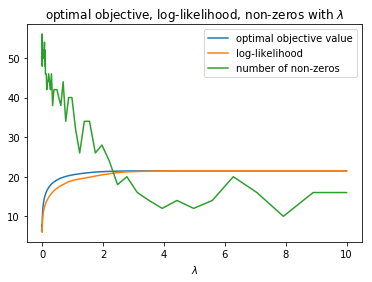

In [4]:
plt.plot(lambd_values, optimal_objective, label='optimal objective value')
plt.plot(lambd_values, log_likelihoods, label='log-likelihood')
plt.plot(lambd_values, number_non_zeros, label='number of non-zeros')
plt.title('optimal objective, log-likelihood, non-zeros with $\lambda$')
plt.xlabel('$\lambda$')
plt.legend()
plt.show()

## Total Variation Denoising

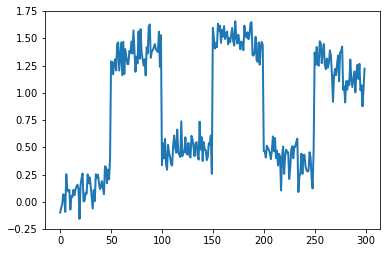

In [5]:
x_corr = pickle.load(open('asgn5q3.pkl', 'rb'))
n = len(x_corr)
plt.plot(x_corr, linewidth=2)
plt.show()

In [6]:
D = diags([-1, 1], [0, 1], shape=(n-1, n)).toarray()
x = cp.Variable((n,1))
problem = cp.Problem(cp.Minimize(cp.norm(x - x_corr, 2) ** 2 + lambd * cp.norm(D*x, 1)))
x_xcorr, Dx = list(), list()

for value in lambd_values:
    lambd.value = value
    problem.solve()
    x_xcorr.append(cp.norm(x.value - x_corr, 2).value ** 2)
    Dx.append(cp.norm(D*x, 1).value)

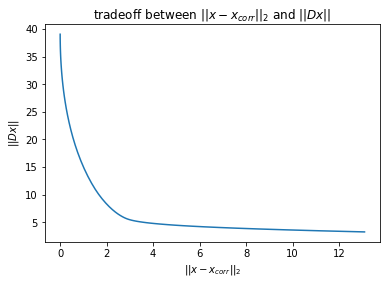

In [7]:
plt.xlabel('$||x-x_{corr}||_2")$')
plt.ylabel('$||Dx||$')
plt.title('tradeoff between $||x-x_{corr}||_2")$ and $||Dx||$')
plt.plot(x_xcorr, Dx)
plt.show()

We can find that when $||Dx||$ is round 5, there is a a clear knee. Therefore, we just need to find the value of $\lambda$ at that point.

In [8]:
for i in range(len(Dx)):
    if Dx[i] >= 5 and Dx[i+1] <= 5:
        break

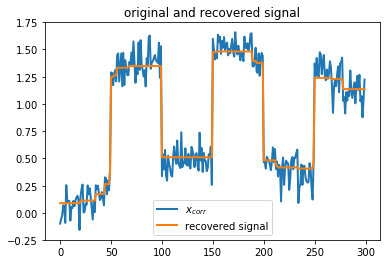

In [10]:
lambd.value = lambd_values[i]
problem.solve()
plt.plot(x_corr, linewidth=2, label='$x_{corr}$')
plt.plot(x.value, linewidth=2, label='recovered signal')
plt.title('original and recovered signal')
plt.legend()
plt.show()